## Dogs vs Cats - with Transfer Learning & Dropout

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import random
from shutil import copyfile

In [ ]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
# download Inception v3 weights

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-10-10 03:57:33--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content/inception_ 100%[===================>]  83.84M   161MB/s    in 0.5s    

2021-10-10 03:57:34 (161 MB/s) - ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [10]:
HEIGHT = 150
WIDTH = 150
NUM_CHANNELS = 3
NUM_CLASSES = 1

In [5]:
# import Inception v3 Model

from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape = (HEIGHT, WIDTH, NUM_CHANNELS), 
                                include_top = False, 
                                weights = None)

In [6]:
# load Inception v3 weights into model

local_weights_file = '/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model.load_weights(local_weights_file)

In [7]:
# set layers to be non-trainable for pre-trained model

for layer in pre_trained_model.layers:
    layer.trainable = False

In [8]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

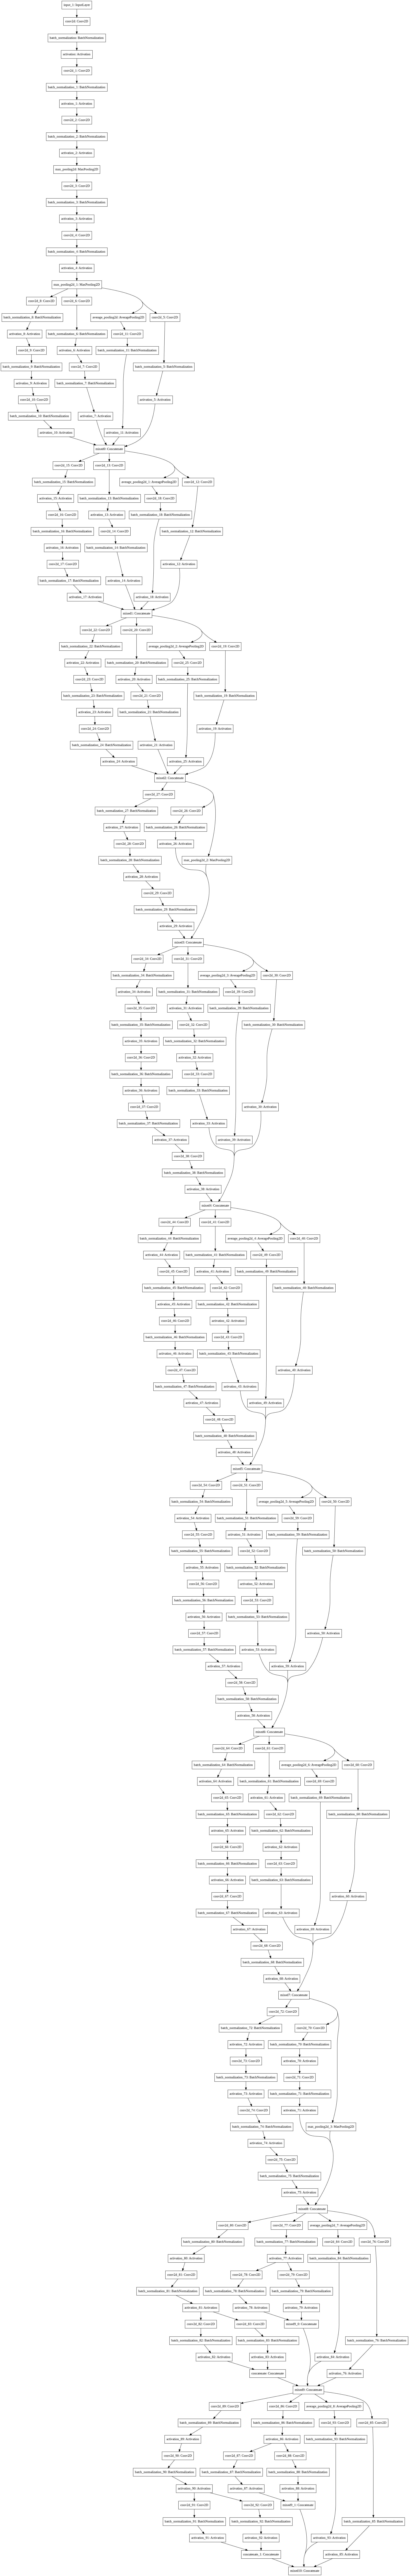

In [9]:
plot_model(pre_trained_model, show_shapes=False, show_layer_names=True)

In [11]:
# obtain last layer output of the pre-trained model

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [12]:
# adding dense layers after pre-trained model

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(NUM_CLASSES, activation='sigmoid')(x)

In [14]:
model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x) 

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

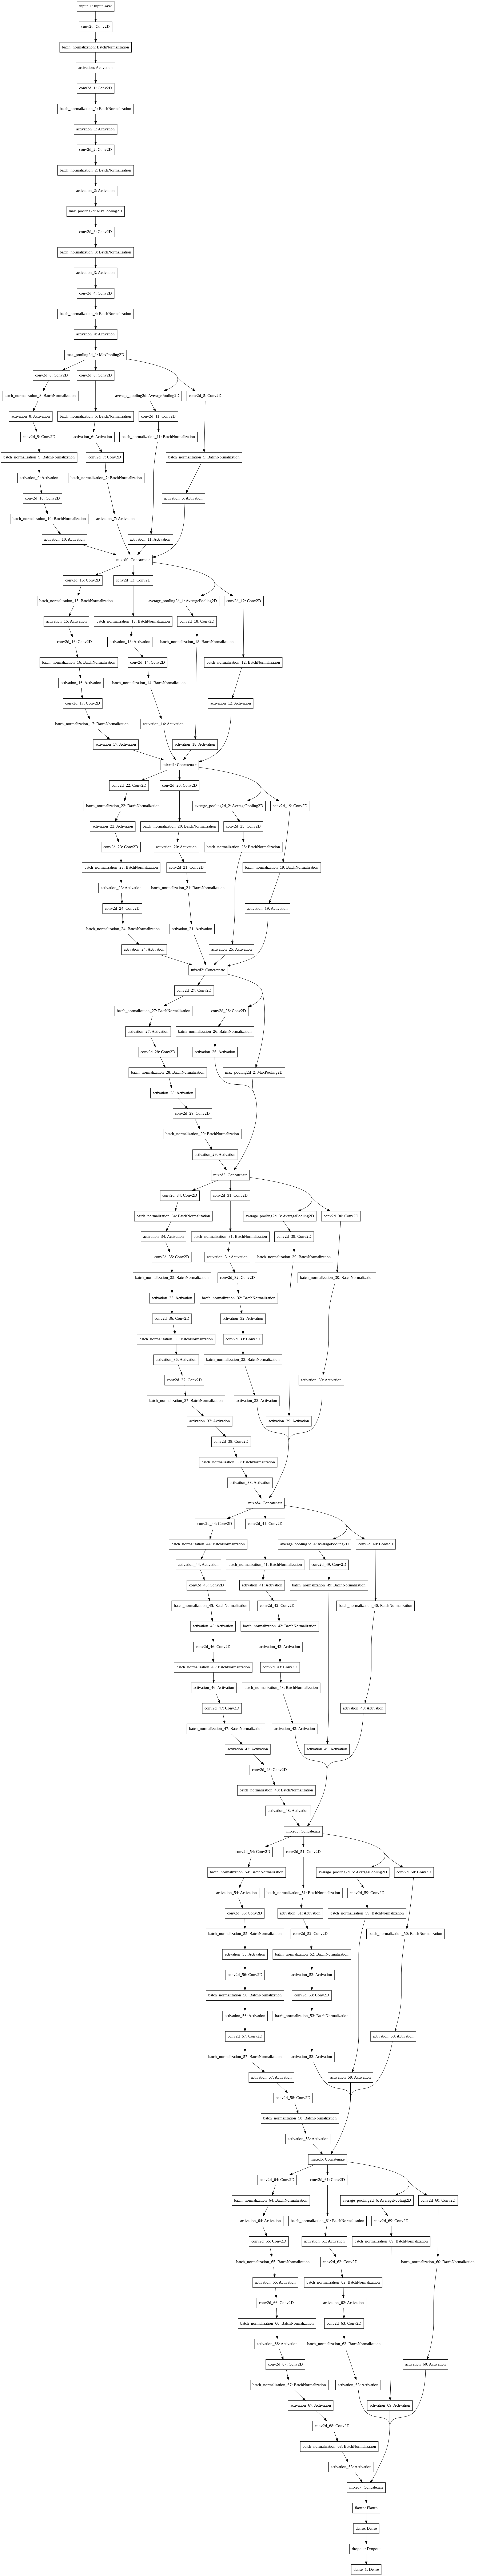

In [16]:
plot_model(model, show_shapes=False, show_layer_names=True)

In [17]:
optimizer   = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [18]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [19]:
# getting the data set

!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /content/cats_and_dogs_filtered.zip

--2021-10-10 04:23:48--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 172.217.212.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   158MB/s    in 0.4s    

2021-10-10 04:23:48 (158 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [20]:
# content -> cats_and_dogs_filtered -> train -> cats, dogs
# content -> cats_and_dogs_filtered -> validation -> cats, dogs

import os
import zipfile

local_zip = '/content/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [21]:
base_dir = '/content/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

In [22]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.691.jpg', 'cat.616.jpg', 'cat.890.jpg', 'cat.950.jpg', 'cat.169.jpg', 'cat.172.jpg', 'cat.180.jpg', 'cat.511.jpg', 'cat.285.jpg', 'cat.847.jpg']
['dog.624.jpg', 'dog.105.jpg', 'dog.896.jpg', 'dog.194.jpg', 'dog.233.jpg', 'dog.602.jpg', 'dog.440.jpg', 'dog.238.jpg', 'dog.836.jpg', 'dog.331.jpg']


In [23]:
print('total training cat images :', len(os.listdir(train_cats_dir)))
print('total training dog images :', len(os.listdir(train_dogs_dir)))

print('total validation cat images :', len(os.listdir(valid_cats_dir)))
print('total validation dog images :', len(os.listdir(valid_dogs_dir)))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')        

train_generator = train_datagen.flow_from_directory(
                          train_dir,   
                          target_size=(150, 150),       # same as input image size
                          batch_size=20,             
                          seed=20,                      
                          class_mode='binary')

Found 2000 images belonging to 2 classes.


In [25]:
valid_datagen = ImageDataGenerator(rescale=1./255.)

valid_generator = valid_datagen.flow_from_directory(
                          valid_dir, 
                          target_size=(150, 150),  
                          batch_size=20,
                          seed=20,
                          class_mode='binary')

Found 1000 images belonging to 2 classes.


In [27]:
early_stopping    = EarlyStopping(monitor='val_loss', patience=7)
reduce_lr         = ReduceLROnPlateau(monitor='val_loss', patience=7, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)

In [28]:
epochs = 20
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [29]:
history = model.fit(train_generator,
                  # steps_per_epoch=100,                          # steps_per_epoch = total training records / batch size = 2000/20
                    validation_data = valid_generator,
                  # validation_steps=50,                          # validation_steps = total validation records / batch size = 1000/20
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/20
100/100 [==============================] - 58s 252ms/step - loss: 0.3368 - accuracy: 0.8655 - val_loss: 0.1150 - val_accuracy: 0.9560
Epoch 2/20
100/100 [==============================] - 23s 233ms/step - loss: 0.1998 - accuracy: 0.9180 - val_loss: 0.1023 - val_accuracy: 0.9650
Epoch 3/20
100/100 [==============================] - 25s 245ms/step - loss: 0.2185 - accuracy: 0.9200 - val_loss: 0.0989 - val_accuracy: 0.9610
Epoch 4/20
100/100 [==============================] - 23s 233ms/step - loss: 0.1891 - accuracy: 0.9365 - val_loss: 0.1089 - val_accuracy: 0.9600
Epoch 5/20
100/100 [==============================] - 24s 241ms/step - loss: 0.2160 - accuracy: 0.9325 - val_loss: 0.1610 - val_accuracy: 0.9480
Epoch 6/20
100/100 [==============================] - 24s 240ms/step - loss: 0.1659 - accuracy: 0.9430 - val_loss: 0.1057 - val_accuracy: 0.9650
Epoch 7/20
100/100 [==============================] - 24s 236ms/step - loss: 0.1951 - accuracy: 0.9360 - val_loss: 0.0974 - val_ac

In [30]:
model.evaluate(valid_generator)

50/50 [==============================] - 5s 89ms/step - loss: 0.1796 - accuracy: 0.9540


[0.17955656349658966, 0.9539999961853027]

<Figure size 432x288 with 0 Axes>

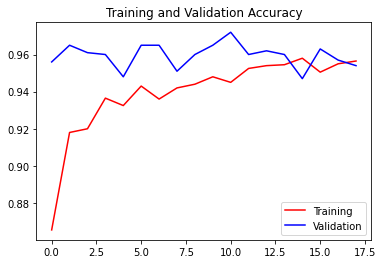

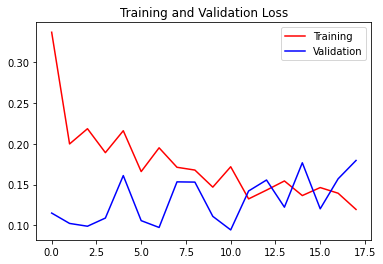

<Figure size 432x288 with 0 Axes>

In [31]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

## Horse vs Human - with Transfer Learning & Dropout

**Question 7**

Apply the same in Horse vs Human dataset.

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

In [ ]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
x = layers.Flatten()(last_output)               # Flatten the output layer to 1 dimension from last o/p
x = layers.Dense(1024, activation='relu')(x)    # Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)    # Add a final sigmoid layer for classification

In [ ]:
model = Model(pre_trained_model.input, x) 

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /content/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /content/validation-horse-or-human.zip

--2021-08-03 18:41:00--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 142.250.101.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/content/horse-or-human.zip’

/content/horse-or-h 100%[===================>] 142.65M   141MB/s    in 1.0s    

2021-08-03 18:41:01 (141 MB/s) - ‘/content/horse-or-human.zip’ saved [149574867/149574867]

--2021-08-03 18:41:01--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.141.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

In [ ]:
import os
import zipfile

local_zip = '/content/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/horse-or-human')

local_zip = '/content/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/validation-horse-or-human')

zip_ref.close()

# Directory with our training horse pictures
train_horse_dir = os.path.join('/content/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/content/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('/content/validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('/content/validation-horse-or-human/humans')

In [ ]:
train_horses_fnames = os.listdir(train_horse_dir)
train_humans_fnames = os.listdir(train_human_dir)
validation_horses_fnames = os.listdir(validation_horse_dir)
validation_humans_fnames = os.listdir(validation_human_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/validation-horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [ ]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
callbacks = myCallback()

history = model.fit(
                    train_generator,
                    steps_per_epoch=51,  
                    epochs=20,
                    verbose=1,
                    validation_data = validation_generator,
                    validation_steps=12,
                    callbacks=[callbacks])

Epoch 1/20
51/51 [==============================] - 17s 240ms/step - loss: 0.1636 - accuracy: 0.9345 - val_loss: 0.0371 - val_accuracy: 0.9833
Epoch 2/20
51/51 [==============================] - 11s 222ms/step - loss: 0.0324 - accuracy: 0.9911 - val_loss: 0.0238 - val_accuracy: 0.9917
Epoch 3/20
51/51 [==============================] - 12s 233ms/step - loss: 0.0153 - accuracy: 0.9940 - val_loss: 0.0149 - val_accuracy: 0.9917
Epoch 4/20
51/51 [==============================] - 12s 231ms/step - loss: 0.0361 - accuracy: 0.9871 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 5/20
51/51 [==============================] - 11s 223ms/step - loss: 0.0050 - accuracy: 0.9980 - val_loss: 0.0276 - val_accuracy: 0.9917
Epoch 6/20
51/51 [==============================] - 11s 218ms/step - loss: 0.0101 - accuracy: 0.9970 - val_loss: 0.0305 - val_accuracy: 0.9958
Epoch 7/20
51/51 [==============================] - 12s 236ms/step - loss: 0.0143 - accuracy: 0.9970 - val_loss: 0.0652 - val_accuracy: 0.9875

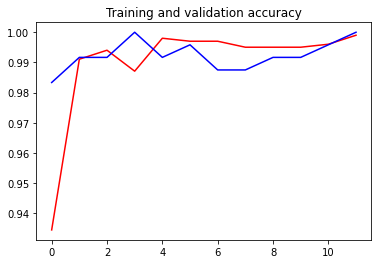

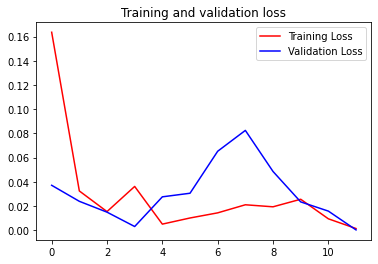

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()